In [4]:
# General
import pandas as pd
import numpy as np
from time import time
import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from ast import literal_eval
import json

# Word2Vec
import multiprocessing
from gensim.models import Word2Vec
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Create and Train Model

In [8]:
# change path to location where data is stored
DATAPATH = '../../data/'
df = pd.read_csv(DATAPATH+'newcleaned_trainfile.csv')
df.ingredients = [literal_eval(x) for x in df.ingredients]
df = df.drop(columns = ['Unnamed: 0'])

df['titlelist'] = [str(row).split() for row in df.title.values]
df['words'] = df.ingredients + df.titlelist

In [11]:
# load w2v model if already trained
RELMODELPATH = '../streamlitapp/models/'
w2v_model = Word2Vec.load(RELMODELPATH+'new_word_embedding_model.model')

# # Retrain or create new model -- uncomment below
# # create W2V model
# cores = multiprocessing.cpu_count() # Count the number of cores in a computer
# w2v_model = Word2Vec(min_count=200,
#                      window=10,
#                      vector_size=3000,
#                      sample=6e-5, 
#                      alpha=0.03, 
#                      min_alpha=0.0007, 
#                      negative=20,
#                      workers=cores-1,
#                      epochs=30)
# t = time()
# w2v_model.build_vocab(df.words, progress_per=10000)
# print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

# # Train W2V model (~6 min)
# t = time()
# w2v_model.train(df.words, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
# print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

# # save model
# w2v_model.save(RELMODELPATH+'new_word_embedding_model.model')


INFO - 08:30:23: loading Word2Vec object from ../streamlitapp/models/new_word_embedding_model.model
INFO - 08:30:23: loading wv recursively from ../streamlitapp/models/new_word_embedding_model.model.wv.* with mmap=None
INFO - 08:30:23: setting ignored attribute cum_table to None
INFO - 08:30:23: Word2Vec lifecycle event {'fname': '../streamlitapp/models/new_word_embedding_model.model', 'datetime': '2022-12-09T08:30:23.180009', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'loaded'}


In [12]:
# Manually search for terms in model
term = 'breakfast'
w2v_model.wv.most_similar(positive=[term])

[('brunch', 0.6333063244819641),
 ('morning', 0.5912337899208069),
 ('overnight', 0.4231472313404083),
 ('scramble', 0.41936707496643066),
 ('strata', 0.41766491532325745),
 ('muffin', 0.413813054561615),
 ('protein', 0.40815165638923645),
 ('waffle', 0.3903578519821167),
 ('omelet', 0.37185612320899963),
 ('flax seed', 0.36754703521728516)]

# Plotting with t-SNE

In [13]:
# helper function for plotting t-SNE
# source for original function - https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.nipy_spectral(np.linspace(0, .95, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        ax = plt.gca()
        ax.scatter(x, y, color=color, label=label, s=60)
        for i, word in enumerate(words):
                ax.annotate(word, alpha=.85, xy=(x[i], y[i]), xytext=(5, 2),
                             textcoords='offset points', ha='right', va='bottom', size=12, weight='bold')
                             
    plt.legend(bbox_to_anchor = (1.15,1), fontsize=14)
    ax.set_title(title, size=18, weight='bold')

    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

c:\Users\jrmcn\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\jrmcn\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


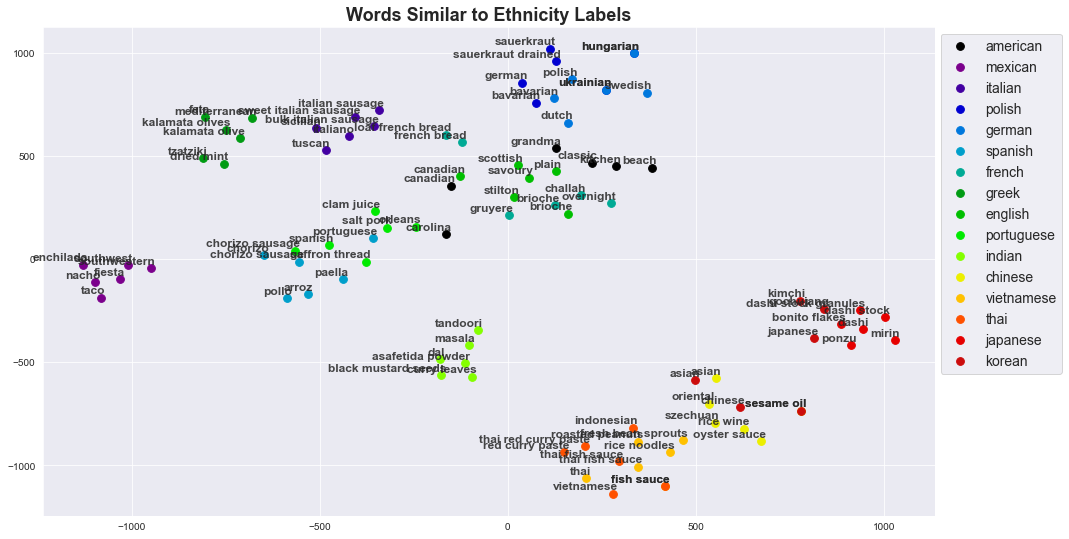

In [14]:
# Plot ethnicity labels
keys = ['american','mexican',
        'italian','polish','german','spanish','french','greek','english','portuguese',
        'indian','chinese','vietnamese','thai','japanese','korean',
       ]

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=6):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=9, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


tsne_plot_similar_words('Words Similar to Ethnicity Labels', keys, embeddings_en_2d, word_clusters, .85)

c:\Users\jrmcn\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\jrmcn\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


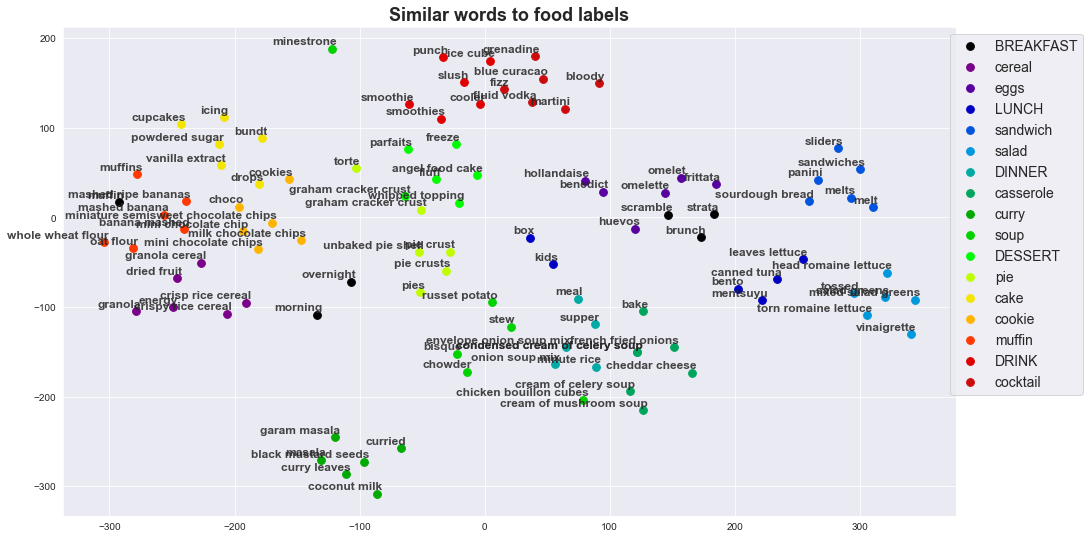

In [16]:
# plot food categories
keys = [
    'BREAKFAST', 'cereal', 'eggs',
    'LUNCH', 'sandwich','salad',
    'DINNER', 'casserole','curry','soup',
    'DESSERT', 'pie','cake','cookie','muffin',
    'DRINK','cocktail'
       ]


embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word.lower(), topn=6):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=16, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


tsne_plot_similar_words('Similar words to food labels', keys, embeddings_en_2d, word_clusters, 0.7)